# Multi-class classification

Softmax regression (aka multinomial logistic regression) is a generalisation of logistic regression that handles multi-class classification. When number of classes is 2, softmax regression reduces to binary logistic regression. 

#### Softmax function

$\sigma(z) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$

where $K$ is number of classes.

\

<img src="https://miro.medium.com/max/4800/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg" alt="drawing" width="300"/>

 

### UCI Datataset
1. [Iris](https://archive.ics.uci.edu/ml/datasets/Iris): Classify into 3 classes based on 4 attributes; 150 examples.
2. [Adult](https://archive.ics.uci.edu/ml/datasets/Adult): Classify whether income exceeds $50K/yr using 14 attributes; 48842 examples.
3. [Wine](https://archive.ics.uci.edu/ml/datasets/Wine): Classify 3 different cultivars based on 13 attributes; 178 examples.

### Content
1. Import libraries
2. Prepare dataset
3. Training hyperparameters
4. Dataloader
4. Model
5. Training
6. Visualisation 


In [4]:
from google.colab import drive
drive.mount('/content/drive')
# modify the following path accordingly
%cd '/content/drive/MyDrive/Colab Notebooks'
%ls -lah './'
%ls '/content/drive/MyDrive/Colab Notebooks/datasets'
#% cd '/content/drive/MyDrive/Colab'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
total 968K
-rw------- 1 root root 388K Aug 25  2021  Contour.ipynb
drwx------ 2 root root 4.0K Sep  1  2021  datasets/
-rw------- 1 root root  61K Sep  3 05:04  LogisticRegression.ipynb
-rw------- 1 root root  30K Aug 20 09:21 'New PyTorch Usage.ipynb'
-rw------- 1 root root  33K Aug 20 08:45 'Numpy Usage.ipynb'
-rw------- 1 root root 2.3K Sep 10  2021  Playground.ipynb
drwx------ 2 root root 4.0K Sep  1  2021  __pycache__/
-rw------- 1 root root 2.5K Aug 17  2021 'PyTorch Usage'
-rw------- 1 root root 351K Apr 14 06:00  ResNet.ipynb
-rw------- 1 root root  16K Mar  4  2022 'SVM Boundary.ipynb'
-rw------- 1 root root  34K Apr 16 09:28  TransformerLanguageModel.ipynb
-rw------- 1 root root 2.8K Oct 28  2021 'Transposed Convolution'
-rw------- 1 root root 3.2K Sep  1  2021  uci.py
-rw------- 1 root root  34K Aug 13  2021  

In [6]:
%ls '/content/drive/MyDrive/Colab Notebooks/datasets'


adult.csv  iris.csv  wikitext-2/  wine.csv


### Import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from uci import iris, adult, wine # these functions load the datasets as Pandas Dataframes
%matplotlib inline


### Prepare dataset

In [8]:
# Dataset (choose from iris, adult or wine)
dataset = 'iris'
dataset_fn = {'iris': iris(), 'adult': adult(), 'wine': wine()}
X, y, df = dataset_fn[dataset]

df.head(n=10) # show the first 10 rows


,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [10]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

# for simplicity, here we are splitting the data into the training set and the
# test set. Rigorous model selection requires splitting into three sets, training, 
# validation, and test. 
# To do that, apply train_test_split once again on X_train and y_train

print('Number of features: ', num_features)
print('Number of classes: ', num_classes)
print('Number of training examples: ', X_train.shape[0])
print('Number of testing examples : ', X_test.shape[0])

# Normalization to zero mean and unit standard deviation
print("before normalization: mean = " + str( X_train.sum(axis=0)) + " std = " + str(X_train.std(axis=0)))
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print("after normalization: mean = " + str(X_train.sum(axis=0))+ " std = " + str(X_train.std(axis=0)))

# apply the feature-level mean and std from the training set
X_test = scaler.transform(X_test)

Number of features:  4
Number of classes:  3
Number of training examples:  105
Number of testing examples :  45
before normalization: mean = [616.5 319.2 393.8 126.1] std = [0.856  0.4524 1.795  0.763 ]
after normalization: mean = [ 0.00586  -0.00403  -0.003906  0.      ] std = [0.9985 1.     0.9995 0.997 ]


### Setting hyperparameters for training

In [11]:
batch_size = 16
num_epochs = 100
learning_rate = 0.4
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Current device:', device)

Current device: cuda


### Dataloader

In [12]:
# Convert to pytorch tensor
X_train_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)
X_test_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)

# Pytorch train and test sets
train = TensorDataset(X_train_tensor,y_train_tensor)
test = TensorDataset(X_test_tensor,y_test_tensor)

# Data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
# You should always shuffle the training dataset.
# Insufficient shuffling leads to biased estimates of the gradient!
# Shuffling the test set does not affect performance.  

### Model

In [56]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(num_features, num_classes) # this is a fully connected layer
    
    def forward(self, x):
        out = self.linear(x) # the outputs are the logits. This is expected by CrossEntropyLoss
        return out

In [58]:
# Create model
model = SoftmaxRegression(num_features, num_classes).to(device)
print('Model: ', model)
# Cross entropy loss
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
# this is SGD without momentum. 

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate) 
# this is SGD with momentum. We will discuss momentum later in the lecture.
# feel free to remove the momentum argument and see what happens

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=0)
# Cosine decay for the learning rate
# feel free to remove the scheduler and see what happens.


Model:  SoftmaxRegression(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)


### Training

In [59]:
def train_func(model, optimizer, criterion, train_loader, device, epoch):
  # this is one epoch of training, i.e., going through the entire training dataset for once. 
  train_loss_ = 0
  correct_train = 0
  total_train = 0

  for i, (train_samples, labels) in enumerate(train_loader):
    train_samples = train_samples.to(device)
    labels = labels.to(device)
  
    # Forward pass
    outputs = model(train_samples)

    # Calculate softmax and cross entropy loss
    loss = criterion(outputs, labels)

    # Compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate train accuracy
    _, predicted = torch.max(outputs, dim=1)

    # Accumulate train loss and acc for monitoring
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum()
    train_loss_ += loss*labels.size(0)
    
  scheduler.step()
  # store train loss and acc
  train_loss = (train_loss_/total_train).item()
  train_acc = (correct_train/total_train).item()

  return train_loss, train_acc 

In [60]:
def eval(model, criterion, test_loader, device):
  test_loss_ = 0
  correct_test = 0
  total_test = 0
  with torch.no_grad():
    for test_samples, test_labels in test_loader:
      test_samples = test_samples.to(device)
      test_labels = test_labels.to(device)
      test_outputs = model(test_samples)
      loss = criterion(test_outputs, test_labels)
      _, test_predicted = torch.max(test_outputs, dim=1)

      # Accumulate test loss and acc for monitoring
      total_test += test_labels.size(0)
      correct_test += (test_predicted == test_labels).sum()
      test_loss_ += loss*test_labels.size(0)

    test_loss = (test_loss_/total_test).item()
    test_acc = (correct_test/total_test).item()
  return test_loss, test_acc

In [61]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(num_epochs):
  train_loss_, train_acc_ = train_func(model, optimizer, criterion, train_loader, device, epoch)
  test_loss_, test_acc_ = eval(model, criterion, test_loader, device)
  if epoch%5 == 0:
    print('Epoch: {}, Train loss: {:.4f}, Test loss: {:.4f}, Train acc: {:.4f}, \
    Test acc: {:.4f}'.format(epoch, train_loss_, test_loss_, train_acc_, test_acc_))
  train_loss.append(train_loss_)
  test_loss.append(test_loss_)
  train_acc.append(train_acc_)
  test_acc.append(test_acc_)

Epoch: 0, Train loss: 0.5472, Test loss: 0.3651, Train acc: 0.7810,     Test acc: 0.8444
Epoch: 5, Train loss: 0.0904, Test loss: 0.0785, Train acc: 0.9714,     Test acc: 0.9778
Epoch: 10, Train loss: 0.0745, Test loss: 0.0646, Train acc: 0.9714,     Test acc: 0.9778
Epoch: 15, Train loss: 0.0717, Test loss: 0.0674, Train acc: 0.9810,     Test acc: 0.9778
Epoch: 20, Train loss: 0.0700, Test loss: 0.0531, Train acc: 0.9619,     Test acc: 0.9778
Epoch: 25, Train loss: 0.0655, Test loss: 0.0470, Train acc: 0.9619,     Test acc: 1.0000
Epoch: 30, Train loss: 0.0672, Test loss: 0.0523, Train acc: 0.9619,     Test acc: 1.0000
Epoch: 35, Train loss: 0.0660, Test loss: 0.0551, Train acc: 0.9810,     Test acc: 0.9778
Epoch: 40, Train loss: 0.0642, Test loss: 0.0468, Train acc: 0.9810,     Test acc: 1.0000
Epoch: 45, Train loss: 0.0657, Test loss: 0.0384, Train acc: 0.9524,     Test acc: 0.9778
Epoch: 50, Train loss: 0.0620, Test loss: 0.0386, Train acc: 0.9714,     Test acc: 1.0000
Epoch: 55, T

### Visualisation

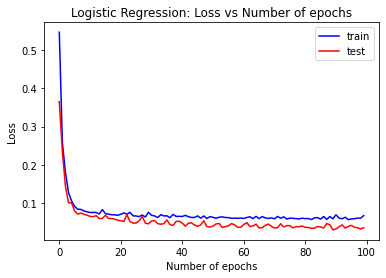

In [62]:
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(test_loss)), test_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of epochs")
plt.legend(['train', 'test'])
plt.show()

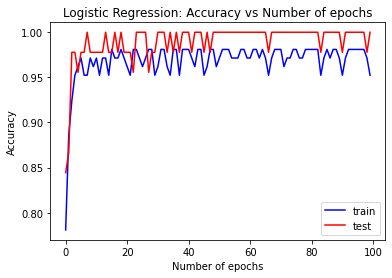

In [63]:
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(test_acc)), test_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Logistic Regression: Accuracy vs Number of epochs")
plt.legend(['train', 'test'])
plt.show()

### References/Resources
1. https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/notebook
2. [Softmax activation](https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60)
